In [ ]:
!pip install h5py=='2.9.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 60.7 MB/s eta 0:00:00
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Understanding Data

Trainset.json contains:
*   qid
*   image_name
*   image_organ
*   answer
*   answer_type
*   question
*   question_type
*   phrase_type

An example is: {"qid": 1, "image_name": "synpic54610.jpg", "image_organ": "HEAD", "answer": "Yes", "answer_type": "CLOSED", "question_type": "PRES", "question": "Are regions of the brain infarcted?", "phrase_type": "freeform"}

VQA_RAD Image Folder contains the images in .jpg format, whose name are the qid as mentioned in the trainset.json.



In [ ]:
import pandas as pd
image_path = '/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/VQA_RAD Image Folder'
imgs_train = json.load(open('/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/trainset.json' , 'r'))      

questions_df = pd.DataFrame(imgs_train)
questions_df.head(5)

,qid,image_name,image_organ,answer,answer_type,question_type,question,phrase_type
0,1,synpic54610.jpg,HEAD,Yes,CLOSED,PRES,Are regions of the brain infarcted?,freeform
1,2,synpic29265.jpg,CHEST,No,CLOSED,ABN,Are the lungs normal appearing?,freeform
2,3,synpic29265.jpg,CHEST,No,CLOSED,PRES,Is there evidence of a pneumothorax,freeform
3,4,synpic28602.jpg,CHEST,ultrasound,OPEN,MODALITY,What type of imaging does this not represent?,freeform
4,5,synpic29265.jpg,CHEST,no,CLOSED,MODALITY,Is this a MRI of the chest?,freeform


## Word Embeddings

A pretained model is used for word to vector conversion, Google News Vector for vectorizing all the questions.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import gensim
from gensim.models import Word2Vec, KeyedVectors

# Loading the pretained model.
model_path = '/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/GoogleNews-vectors-negative300.bin'            # Path where the model is stored
model_w2v = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)                                            # Loading the model using gensim

## Extraction of features

Extracting the features  in questions.

*   Input is a sentence
*   Output is the Word Embedding of the sentence 





In [ ]:
import json
import h5py
import numpy as np
import pandas as pd
import copy
from random import shuffle, seed
import sys
import os.path
import argparse
import glob
import numpy as np
import scipy.io
import pdb
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import gensim
import re
import cv2
import matplotlib.pyplot as plt

In [ ]:
def extract_feat(doc):
    feat = []
    for word in doc:
        try:
            feat.append(model_w2v[word])
        except:
            pass
    return feat

In [ ]:
import re

def tokenize(sentence):
    ''' Perform Tokenization '''
    return [i for i in re.split(r"([-.\"',:? !$#@~()*&\^%;/\\+<>\n=])", sentence) if i!='' and i!=' ' and i!='\n'];

## Preprocessing the questions




*   Input is the question from trainset.json

*   The task is to perform tokenization and lowering of the question

*   Output is the Embedded version of the question




In [ ]:
def prepro_question(imgs, method):
    # preprocess all the question
    print('example processed tokens:')

    for i,img in enumerate(imgs):
        s = img['question'].lower()
        if method == 'nltk':
            txt = word_tokenize(str(s).lower())
        else:
            txt = tokenize(s)
        img['processed_tokens'] = txt
        if i < 10: print(txt)
        if i % 1000 == 0:
            sys.stdout.write("processing %d/%d (%.2f%% done)   \r" %  (i, len(img), i*100.0/len(imgs)) )
            sys.stdout.flush()   
    return imgs

In [ ]:
# Visualizing the type of answers present in the dataset

def get_top_answers(imgs, num_ans):
    counts = {}
    for img in imgs:
        try:
            ans = img['answer'].lower()  
        except :
            ans = str(img['answer'])
        counts[ans] = counts.get(ans, 0) + 1

    cw = sorted([(count,w) for w,count in counts.items()], reverse=True)
    print('top answer and their counts:') 
    print('\n'.join(map(str,cw[:20])))
    
    vocab = []
    for i in range(min(num_ans,len(cw))):
        vocab.append(cw[i][1])

    return vocab[:num_ans]

In [ ]:
imgs_train = json.load(open('/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/trainset.json' , 'r'))      
num_ans = 1000

top_ans = get_top_answers(imgs_train, num_ans)    

atoi = {w:i for i,w in enumerate(top_ans)}                   # Word : Count
itoa = {i:w for i,w in enumerate(top_ans)}                   # Count : Word
feat_dim = 300                                               # 300 Dimensional Vector
                                           
imgs_data_train = json.load(open('/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/trainset.json' , 'r'))  # trainset.json
num_ans = 10                                                  # 10 represents the top 10 answers to a picture
method = 'nltk'
max_length = 21                                               # Max Length of the question
dir_path = "/content/drive/MyDrive/Colab Notebooks/newh5"     # The path where we will be storing .h5 file
N = len(imgs_data_train)

image_path = '/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/VQA_RAD Image Folder'

top answer and their counts:
(884, 'no')
(829, 'yes')
(35, 'right')
(31, 'axial')
(23, 'left')
(15, 'fat')
(14, 'pa')
(12, 'right lung')
(12, 'pancreas')
(12, 'one')
(11, 'left kidney')
(11, 'diffuse')
(10, 'right upper lobe')
(10, 'right sided pleural effusion')
(10, 'right side')
(10, 'ct')
(10, 'brain')
(9, 'lateral ventricles')
(9, 'bilateral')
(8, 'subarachnoid')


## Saving the data

The data is saved in a .h5 file that contains:


*   The questions which are transformed to vectors by word embeddings with Google news vector

*   The answers which are the labeled arrays 



In [ ]:
def save_data():
        for i,img in enumerate(imgs_data_train):
            #print('X' , img['ques_id'])
            img_path = image_path+img['image_name']  

            s = img['question']
            print(i,s)   # Print the number and the question
            if method == 'nltk':
                try:
                    txt = word_tokenize(str(s).lower())
                except :
                    txt = str(s)
            else:
                    txt = tokenize(s)

            img['processed_tokens'] = txt            
            question_id = img['qid']
            feat = np.array(extract_feat(img['processed_tokens']))
            label_arrays = np.zeros((1, max_length, feat_dim), dtype='float32')
            label_length = min(max_length, len(feat)) # record the length of this sequence
            label_arrays[0, :label_length, :] = feat
            try:
                ans_arrays = atoi[img['answer'].lower()]
            except :
                ans_arrays = atoi[str(img['answer'])]

            f = h5py.File(os.path.join( dir_path , str(question_id) + '.h5'), "w")
            f.create_dataset("ques_train", dtype='float32', data=label_arrays)
            f.create_dataset("answers", dtype='uint32', data=ans_arrays)
            f.create_dataset("image_vector", dtype='float32', data=[])

            f.close()
        return    
 
data = save_data()

0 Are regions of the brain infarcted?
1 Are the lungs normal appearing?
2 Is there evidence of a pneumothorax
3 What type of imaging does this not represent?
4 Is this a MRI of the chest?
5 What is not pictured in this image?
6 Is the trachea midline?
7 Is there evidence of an aortic aneurysm?
8 Where is the abnormality?
9 Is there blunting of the costovertebral angles?
10 Which organ system is abnormal in this image?
11 Where is the pathology in this image?
12 Is there a pneumothorax?
13 What type of imaging is this?
14 What organ system is pictured?
15 Is there a fracture?
16 Is there swelling of the grey matter?
17 Is this an anterior posterior image?
18 Is this the brain?
19 Is there air under the diaphragm?
20 What type of image is this?
21 Is this a CT image?
22 Is this an anterior-posterior image
23 In what plane is this image oriented?
24 Is there a skull fracture pictured?
25 Are there >12 of ribs? 
26 Is/Are the lungs normal size?
27 Is/Are there a rib fracture?
28 Is/Are the

## Preprocessing Image

For preprocessing the image, we would use the VGG16 preprocessing layer, which would help in coverting the image dimension.

 It takes a tensor as an input, and returns a pre processed version of the image

In [ ]:
import tensorflow as tf
import numpy as np
import keras, h5py
import pandas as pd
import os
import json
from tqdm import tqdm 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from keras.applications.vgg16 import VGG16
import keras.activations
import keras.backend as kbe
from keras.callbacks import EarlyStopping
import tensorflow.keras.layers as layers
from keras.layers import Activation, Add, Concatenate, Conv1D, Dense, Dropout, Embedding, Softmax
from keras.layers import Input, GlobalMaxPooling1D, Lambda, Multiply, RepeatVector, Reshape
from keras.layers import BatchNormalization 
from keras.models import Model
from keras.regularizers import l2
import pickle
from pprint import pprint

In [ ]:
def image_layer(input_shape):
    base_model = tf.keras.applications.VGG16(input_shape=input_shape, include_top=False,weights='imagenet')
    base_model.trainable = False 
    x = base_model.layers[-2].output  # Shape would be (28*28*512)
    x = tf.reshape(x , [-1,x.shape[2]*x.shape[1] , x.shape[3]]) # Shape would be (1,784,512)
    x = tf.keras.layers.Dense(1024)                            
    return x

In [ ]:
# Takes tensor as an input and returns a preprocessed version of image
def vgg_preprocessing(model,image):
    return model(image)

The output is the list containing four elements in a tuple:


*   preprocessed version of the image
*   embedded question
*   embedded answer
*   question id




In [ ]:
def load_data():

  images = []
  questions = []
  answers = []
  ids = []
              
  data = imgs_data_train   
  model = image_layer(input_shape = (448,448,3))            # Making VGG16 Model
  
  for i, img in enumerate(data):
        
    img_path = img['image_name']  # Image Name
    question_id = img['qid']      # Question id
            
    with h5py.File(os.path.join(dir_path,str(question_id) + '.h5'),'r') as h5f:
      question = h5f['.']['ques_train'].value                                         # Embedded question
      answer = h5f['.']['answers'].value                                              # Embedded answer
          
    image = cv2.imread(os.path.join('/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/VQA_RAD Image Folder',img_path) , cv2.IMREAD_COLOR) # Reading the image
    image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
    image = cv2.resize(image , (448,448))                 # Reshape

    images.append(image)
    questions.append(np.array(question))
    answers.append(np.array(answer))
    ids.append(question_id)              
        
  questions = np.reshape(np.array(questions) , [-1,max_length,feat_dim])
  return (np.array(images) , questions ,np.array(answers) , np.array(ids))

In [ ]:
imgs_train = json.load(open('/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/trainset.json' , 'r'))
num_ans = 1000
top_ans = get_top_answers(imgs_train, num_ans )
atoi = {w:i for i,w in enumerate(top_ans)}
itoa = {i:w for i,w in enumerate(top_ans)}
feat_dim = 300
imgs_data_train = json.load(open('/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/trainset.json' , 'r'))
num_ans = 10
method = 'nltk'
max_length = 21
dir_path = "/content/drive/MyDrive/Colab Notebooks/newh5"
N = len(imgs_data_train)

In [ ]:
datagen = load_data()   # Load the Data

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
images, questions, answers, ids =datagen[0], datagen[1], datagen[2], datagen[3]

print("Images have a size of:", images.shape)
print("Questions have a size of:", questions.shape)
print("Answers have a size of:", answers.shape)
print("Ids have a size of:", ids.shape)


Images have a size of: (3064, 448, 448, 3)
Questions have a size of: (3064, 21, 300)
Answers have a size of: (3064,)
Ids have a size of: (3064,)


## Saving the data


The data is saved in a .h5 file that contains:


*   The questions which are transformed to vectors by word embeddings with Google news vector



*   The answers which are the labeled arrays

*   The images preprocessed with VGG16. 



In [ ]:
dir_path = r'/content/drive/MyDrive/Colab Notebooks/newh5' 
m = 100
for i in range(images.shape[0]):
    ans_array = answers[i]
    image_array = images[i]
    quest_array = questions[i]
    question_id = ids[i]
    f = h5py.File(os.path.join(dir_path , str(question_id) + '.h5'), "w") # Loading the 'h5 file
    f.create_dataset("ques_train", dtype='float32', data=quest_array) # Question Embedding
    f.create_dataset("image_vector", dtype='float32', data=image_array) # Image Embedding 
    f.create_dataset("answers", dtype='uint32', data=ans_array)      # Answers in embedded form

    f.close()
    

.h5 file now contains images, questions and answers



##  Further Preprocessing of images

*   Pre-process the image to make it of the same size of that of question embedding.

*   Then the question layer is passed through LSTM, and preprocessed image is passed through dense network.
*   After that both the vectors are concatenated and passed through dense layers, and final layer with softmax function.

*   The loss function is Sparse Categorical Cross Entropy, optimizer is Adam with learning rate of 0.01, and batch size of 32, and for 50 epochs



In [ ]:
import os,h5py
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model
import warnings
warnings.filterwarnings('ignore')

# Preprocessing with the VGG 16 Model  

model = tf.keras.applications.VGG16(include_top=False,weights='imagenet',
        input_shape=(448,448,3))
last_layer = model.layers[-1].output                   # Last layer has an output layer of (14,14,512)
model = Model(model.input,last_layer)
model.trainable = False

In [ ]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 448, 448, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 448, 448, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 224, 224, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 224, 224, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 224, 224, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 112, 112, 128)     0     

In [ ]:
#Preprocessing with VGG Netowrk

def extract_feature(image):
    image = model(image)
    return image           # Shape is (196,512)

In [ ]:
dimen_red = tf.keras.Sequential()  # Use for converting (196,512) -> (21,300)
dimen_red.add(tf.keras.layers.Conv2D(300,kernel_size=(1,1),input_shape= (14,14,512)))
dimen_red.add(tf.keras.layers.Reshape((196,300)))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network
dimen_red.add(tf.keras.layers.Dense(21))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network

In [ ]:
train_dir = r'/content/drive/MyDrive/Colab Notebooks/newh5/'
images = []
ans = []
ques = []
count = 0
content = os.listdir(train_dir)[:500]   # Taking only 500 samples--> The GPU Memory became full after this
length = len(content)


In [ ]:
for i in content:
  # Reading the data
  file = h5py.File(train_dir+i)
  images.append(np.array(file['.']['image_vector'].value))
  ans.append(np.array(file['.']['answers'].value))
  ques.append(np.array(file['.']['ques_train'].value))

In [ ]:
images = tf.convert_to_tensor(np.array(images))   
ans = tf.convert_to_tensor(np.array(ans))
ques = tf.convert_to_tensor(np.array(ques))

In [ ]:
l = []
length = images.shape[0]
for i,j in enumerate(images):
  l.append(model(tf.reshape(j,[1,448,448,3])))
  if i%100 ==0:
    print("The count is:",i,"and the percentage proportion is:",round(100*i/length,2),'%') 

images = tf.convert_to_tensor(np.array(l) )

The count is: 0 and the percentage proportion is: 0.0 %
The count is: 100 and the percentage proportion is: 20.0 %
The count is: 200 and the percentage proportion is: 40.0 %
The count is: 300 and the percentage proportion is: 60.0 %
The count is: 400 and the percentage proportion is: 80.0 %


In [ ]:
l = []
length = images.shape[0]
for i,j in enumerate(images):
  l.append(dimen_red(j))     # Making it to the same shape as that of question embedding
  if i%100 ==0:
    print("The count is:",i,"and the percentage proportion is:",round(100*i/length,2),'%')
images = tf.convert_to_tensor(np.array(l))

The count is: 0 and the percentage proportion is: 0.0 %
The count is: 100 and the percentage proportion is: 20.0 %
The count is: 200 and the percentage proportion is: 40.0 %
The count is: 300 and the percentage proportion is: 60.0 %
The count is: 400 and the percentage proportion is: 80.0 %


In [ ]:
images = tf.reshape(images,[length,21,300])
img = images          #Tensor containing images
que = ques            # Tensor containing question vector
img = img/255.0       # Normalizing

In [ ]:
que.shape,img.shape

(TensorShape([500, 21, 300]), TensorShape([500, 21, 300]))

In [ ]:
ques = tf.keras.layers.Input((21,300))  # Input Model (for ques)
images = tf.keras.layers.Input((21,300)) # Input Model (for images)

## Model Building


*   We use Dense network with tanh activation for preprocessed images.

*   The question layer is passed through LSTM.
*   After that both the vectors are concatenated and passed through dense layers, and final layer with softmax function.




In [ ]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D,Flatten,Concatenate

#Imagica is for the preprocessing of the image part
imagica = Dense(512,activation='tanh')(images)
imagica = Dense(512,activation='tanh')(images)


#quesa is for the ques layer, which means preprocessing of the question layer
quesa = LSTM(512, dropout = 0.3,return_sequences = True,input_shape = (21,300))(ques)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)

#Concatenating both image and the question layer
quesa = Concatenate()([quesa,imagica])
quesa = Flatten()(quesa)
out = tf.keras.layers.Dense(476,activation='softmax')(quesa) # Final output has 476 different categories, you can check by finding length of uniquue answers :)
     

## Plotting the model

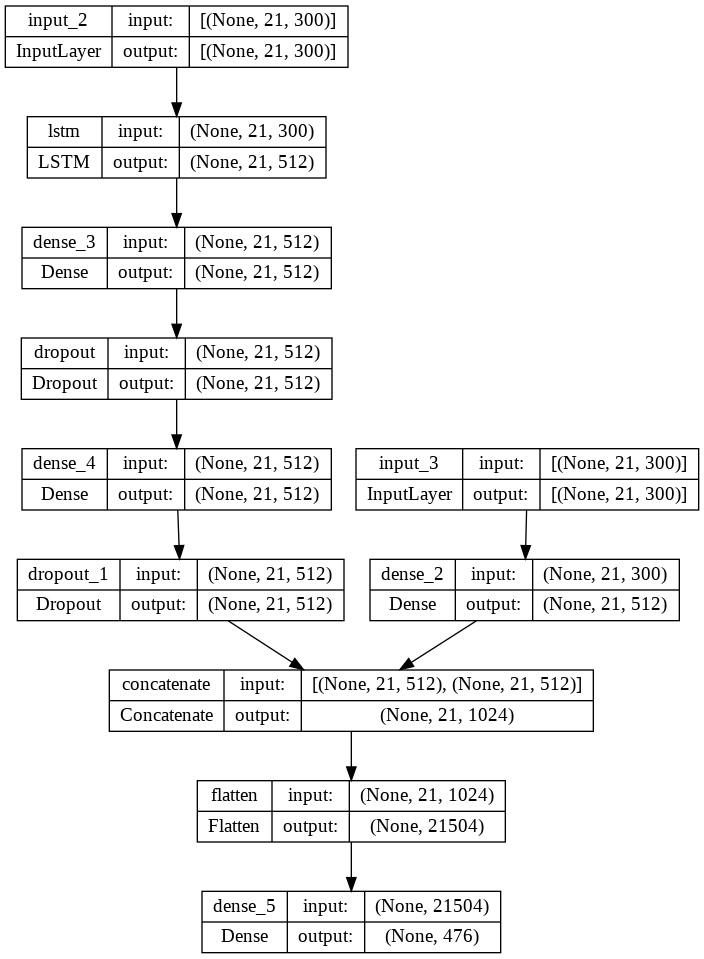

In [ ]:
from keras.utils.vis_utils import plot_model
model = Model([ques,images],[out])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Compiling and fitting the model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss ='sparse_categorical_crossentropy',metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 21, 300)]    0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 21, 512)      1665024     ['input_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 21, 512)      262656      ['lstm[0][0]']                   
                                                                                                  
 dropout (Dropout)              (None, 21, 512)      0           ['dense_3[0][0]']                
                                                                                            

In [ ]:
model.fit([img, que], ans, epochs = 500, batch_size=32, verbose=1)

Epoch 1/500
16/16 [==============================] - 0s 15ms/step - loss: 0.3002 - accuracy: 0.9860
Epoch 2/500
16/16 [==============================] - 0s 12ms/step - loss: 0.6143 - accuracy: 0.9820
Epoch 3/500
16/16 [==============================] - 0s 11ms/step - loss: 0.5374 - accuracy: 0.9820
Epoch 4/500
16/16 [==============================] - 0s 11ms/step - loss: 0.1831 - accuracy: 0.9860
Epoch 5/500
16/16 [==============================] - 0s 11ms/step - loss: 0.4582 - accuracy: 0.9880
Epoch 6/500
16/16 [==============================] - 0s 11ms/step - loss: 0.4178 - accuracy: 0.9820
Epoch 7/500
16/16 [==============================] - 0s 12ms/step - loss: 0.3231 - accuracy: 0.9860
Epoch 8/500
16/16 [==============================] - 0s 12ms/step - loss: 0.5235 - accuracy: 0.9840
Epoch 9/500
16/16 [==============================] - 0s 11ms/step - loss: 0.3956 - accuracy: 0.9840
Epoch 10/500
16/16 [==============================] - 0s 11ms/step - loss: 0.6112 - accuracy: 0.9860

## Model Prediction and Analysis

In [ ]:
prediction = tf.argmax(model.predict([img, que]),axis=1).numpy()

16/16 [==============================] - 1s 6ms/step


In [ ]:
img_path = '/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/VQA_RAD Image Folder/'
import json
x = open('/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/trainset.json','r')
train = json.load(x)
train[0]

{'qid': 1,
 'image_name': 'synpic54610.jpg',
 'image_organ': 'HEAD',
 'answer': 'Yes',
 'answer_type': 'CLOSED',
 'question_type': 'PRES',
 'question': 'Are regions of the brain infarcted?',
 'phrase_type': 'freeform'}

## Result

The Question is: What type of imaging does this not represent?
The answer is:  Actual: ultrasound Prediction: ultrasound


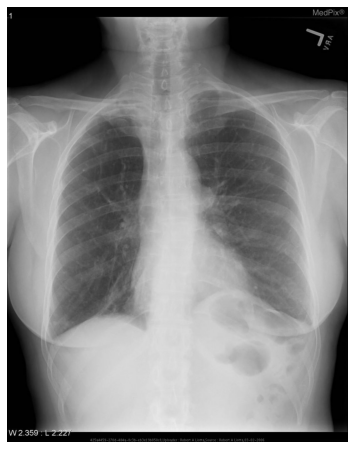

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# for i in range(760,770,2):
plt.figure(figsize=(10,8))
image = cv2.imread(img_path+ train[3]['image_name'])
plt.imshow(image)

value = " Actual: "+str(train[3]['answer']) + " Prediction: " + itoa[prediction[3]]

plt.axis('off')
print("The Question is:",train[3]['question'])
print("The answer is:",value)
plt.show()